# Transfer Learning using MobileNetV2
input shape (224,224,3)


In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#import required libraries
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [ ]:
#Setting seed

import numpy as np

seed_value = 85

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for TensorFlow global random seed
tf.random.set_seed(seed_value)

# Set seed for TensorFlow operation-level random seed (if needed)
#tf.random.experimental.set_seed(seed_value)

In [1]:
#Link of the dataset
link = "https://drive.google.com/file/d/17CmqEyh-v2qqLm5sz0cjzPrIji5anPDl/view?usp=share_link"

In [ ]:
#Parse ID from the link
id = link.split('d/')[1].split('/view?')[0]
print (id)

17CmqEyh-v2qqLm5sz0cjzPrIji5anPDl


In [ ]:
#Get the specific file
downloaded = drive.CreateFile({'id':id})  #drive from PyDrive
downloaded.GetContentFile('DATA_FIX_FINAL_NODEBATT.zip')

In [ ]:
#Extracting file from ZIP
import zipfile
zip_file = 'DATA_FIX_FINAL_NODEBATT.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
#Specify training and validation directories
train_dir = '/content/DATA_FIX_FINAL_NODEBATT/TRAIN'
val_dir = '/content/DATA_FIX_FINAL_NODEBATT/TEST'

In [ ]:
# Define the training and validation base directories for each classes (PET, HDPE, PP)

# Directory with training PET pictures
train_PET_dir = os.path.join(train_dir, 'PET')
# Directory with training HDPE pictures
train_HDPE_dir = os.path.join(train_dir, 'HDPE')
# Directory with training PP pictures
train_PP_dir = os.path.join(train_dir, 'PP')
# Directory with validation PET pictures
val_PET_dir = os.path.join(val_dir, 'PET')
# Directory with validation HDPE pictures
val_HDPE_dir = os.path.join(val_dir, 'HDPE')
# Directory with validation PP pictures
val_PP_dir = os.path.join(val_dir, 'PP')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_PET_dir))} images of PET for training.\n")
print(f"There are {len(os.listdir(train_HDPE_dir))} images of HDPE for training.\n")
print(f"There are {len(os.listdir(train_PP_dir))} images of PP for training.\n")
print(f"There are {len(os.listdir(val_PET_dir))} images of PET for validation.\n")
print(f"There are {len(os.listdir(val_HDPE_dir))} images of HDPE for validation.\n")
print(f"There are {len(os.listdir(val_PP_dir))} images of PP for validation.\n")

There are 2400 images of PET for training.

There are 2400 images of HDPE for training.

There are 2400 images of PP for training.

There are 600 images of PET for validation.

There are 600 images of HDPE for validation.

There are 600 images of PP for validation.



Sample PET image:


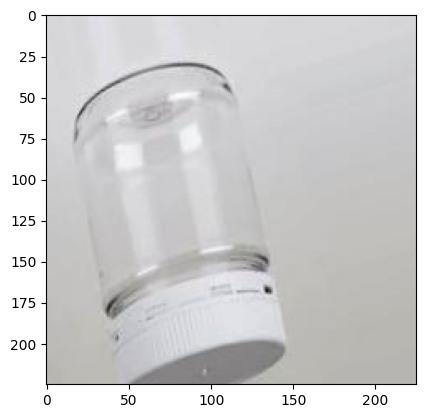


Sample HDPE image:


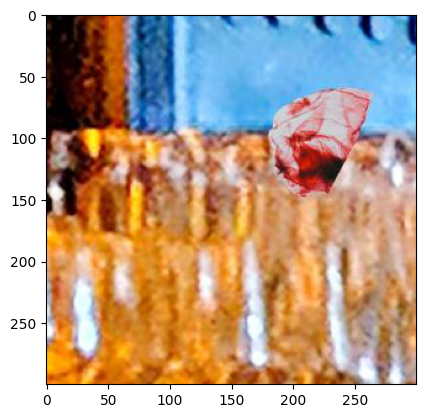


Sample PP image:


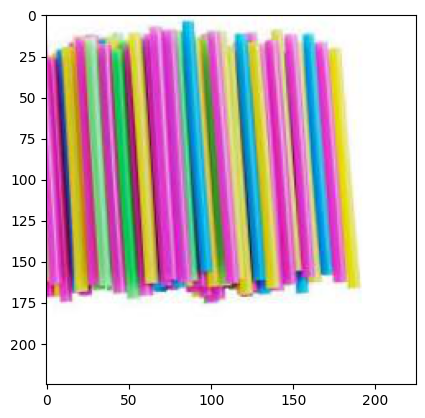

In [ ]:
#Take a look at a sample image from each class
print("Sample PET image:")
plt.imshow(load_img(f"{os.path.join(train_PET_dir, os.listdir(train_PET_dir)[88])}"))
plt.show()

print("\nSample HDPE image:")
plt.imshow(load_img(f"{os.path.join(train_HDPE_dir, os.listdir(train_HDPE_dir)[99])}"))
plt.show()

print("\nSample PP image:")
plt.imshow(load_img(f"{os.path.join(train_PP_dir, os.listdir(train_PP_dir)[111])}"))
plt.show()

In [ ]:
#Code to check image size from each class (NOTE: THIS DOES NOT REPRESENT THE WHOLE CLASS! it is possible that the example shows the same size for all classes but it is actually not)
# Load the first example from each class
sample_PET_image  = load_img(f"{os.path.join(train_PET_dir, os.listdir(train_PET_dir)[88])}")
sample_HDPE_image  = load_img(f"{os.path.join(train_HDPE_dir, os.listdir(train_HDPE_dir)[99])}")
sample_PP_image  = load_img(f"{os.path.join(train_PP_dir, os.listdir(train_PP_dir)[111])}")

# Convert the image into its numpy array representation
sample_PET_array = img_to_array(sample_PET_image)
sample_HDPE_array = img_to_array(sample_HDPE_image)
sample_PP_array = img_to_array(sample_PP_image)

print(f"Sample PET image has shape: {sample_PET_array.shape}")
print(f"Sample HDPE has shape: {sample_PET_array.shape}")
print(f"Sample PP has shape: {sample_PET_array.shape}")

Sample PET image has shape: (225, 225, 3)
Sample HDPE has shape: (225, 225, 3)
Sample PP has shape: (225, 225, 3)


Resizing all image from all classes into the same size (224,224) using cropping and padding


You only need to run these for the first time


after resizing, it will save the resized image back to the original file path

In [ ]:
import os
from PIL import Image

# Define the target shape
target_size = (224, 224)

# Specify the directory containing the images
image_dir = train_PET_dir

# Iterate over all the image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)

        # Open and resize the image while preserving aspect ratio
        image = Image.open(image_path)
        image.thumbnail(target_size, Image.ANTIALIAS)

        # Pad or crop the image to the target shape
        padded_image = Image.new("RGB", target_size)
        padded_image.paste(
            image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
        )

        # Save the resized image back to the original file path
        padded_image.save(image_path)

In [ ]:
# Define the target shape
target_size = (224, 224)

# Specify the directory containing the images
image_dir = train_HDPE_dir

# Iterate over all the image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)

        # Open and resize the image while preserving aspect ratio
        image = Image.open(image_path)
        image.thumbnail(target_size, Image.ANTIALIAS)

        # Pad or crop the image to the target shape
        padded_image = Image.new("RGB", target_size)
        padded_image.paste(
            image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
        )

        # Save the resized image back to the original file path
        padded_image.save(image_path)

In [ ]:
# Define the target shape
target_size = (224, 224)

# Specify the directory containing the images
image_dir = train_PP_dir

# Iterate over all the image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)

        # Open and resize the image while preserving aspect ratio
        image = Image.open(image_path)
        image.thumbnail(target_size, Image.ANTIALIAS)

        # Pad or crop the image to the target shape
        padded_image = Image.new("RGB", target_size)
        padded_image.paste(
            image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
        )

        # Save the resized image back to the original file path
        padded_image.save(image_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Define the target shape
target_size = (224, 224)

# Specify the directory containing the images
image_dir = val_PET_dir

# Iterate over all the image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)

        # Open and resize the image while preserving aspect ratio
        image = Image.open(image_path)
        image.thumbnail(target_size, Image.ANTIALIAS)

        # Pad or crop the image to the target shape
        padded_image = Image.new("RGB", target_size)
        padded_image.paste(
            image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
        )

        # Save the resized image back to the original file path
        padded_image.save(image_path)

In [ ]:
# Define the target shape
target_size = (224, 224)

# Specify the directory containing the images
image_dir = val_HDPE_dir

# Iterate over all the image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)

        # Open and resize the image while preserving aspect ratio
        image = Image.open(image_path)
        image.thumbnail(target_size, Image.ANTIALIAS)

        # Pad or crop the image to the target shape
        padded_image = Image.new("RGB", target_size)
        padded_image.paste(
            image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
        )

        # Save the resized image back to the original file path
        padded_image.save(image_path)

In [ ]:
# Define the target shape
target_size = (224, 224)

# Specify the directory containing the images
image_dir = val_PP_dir

# Iterate over all the image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)

        # Open and resize the image while preserving aspect ratio
        image = Image.open(image_path)
        image.thumbnail(target_size, Image.ANTIALIAS)

        # Pad or crop the image to the target shape
        padded_image = Image.new("RGB", target_size)
        padded_image.paste(
            image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
        )

        # Save the resized image back to the original file path
        padded_image.save(image_path)

Code to make sure all images are of the same size


Run all of these and it should not give any output


If it gives any output it means there are still images with different shape

In [ ]:
import os
import cv2

# Specify the directory containing the resized images
resized_dir = train_PET_dir

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(resized_dir) if f.endswith(".jpg") or f.endswith(".png")]

# Load the first image to get the reference shape
first_image_path = os.path.join(resized_dir, image_files[0])
reference_image = cv2.imread(first_image_path)
reference_shape = reference_image.shape[:2]

# Iterate over the remaining images and compare their shapes with the reference shape
for image_file in image_files[1:]:
    image_path = os.path.join(resized_dir, image_file)
    image = cv2.imread(image_path)
    if image.shape[:2] != reference_shape:
        print(f"Image {image_file} has a different shape: {image.shape[:2]}")

In [ ]:
import os
import cv2

# Specify the directory containing the resized images
resized_dir = train_HDPE_dir

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(resized_dir) if f.endswith(".jpg") or f.endswith(".png")]

# Load the first image to get the reference shape
first_image_path = os.path.join(resized_dir, image_files[0])
reference_image = cv2.imread(first_image_path)
reference_shape = reference_image.shape[:2]

# Iterate over the remaining images and compare their shapes with the reference shape
for image_file in image_files[1:]:
    image_path = os.path.join(resized_dir, image_file)
    image = cv2.imread(image_path)
    if image.shape[:2] != reference_shape:
        print(f"Image {image_file} has a different shape: {image.shape[:2]}")

In [ ]:
# Specify the directory containing the resized images
resized_dir = train_PP_dir

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(resized_dir) if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".jpeg")]

# Load the first image to get the reference shape
first_image_path = os.path.join(resized_dir, image_files[0])
reference_image = cv2.imread(first_image_path)
reference_shape = reference_image.shape[:2]

# Iterate over the remaining images and compare their shapes with the reference shape
for image_file in image_files[1:]:
    image_path = os.path.join(resized_dir, image_file)
    image = cv2.imread(image_path)
    if image.shape[:2] != reference_shape:
        print(f"Image {image_file} has a different shape: {image.shape[:2]}")

In [ ]:
# Specify the directory containing the resized images
resized_dir = val_PET_dir

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(resized_dir) if f.endswith(".jpg") or f.endswith(".png")]

# Load the first image to get the reference shape
first_image_path = os.path.join(resized_dir, image_files[0])
reference_image = cv2.imread(first_image_path)
reference_shape = reference_image.shape[:2]

# Iterate over the remaining images and compare their shapes with the reference shape
for image_file in image_files[1:]:
    image_path = os.path.join(resized_dir, image_file)
    image = cv2.imread(image_path)
    if image.shape[:2] != reference_shape:
        print(f"Image {image_file} has a different shape: {image.shape[:2]}")

In [ ]:
# Specify the directory containing the resized images
resized_dir = val_HDPE_dir

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(resized_dir) if f.endswith(".jpg") or f.endswith(".png")]

# Load the first image to get the reference shape
first_image_path = os.path.join(resized_dir, image_files[0])
reference_image = cv2.imread(first_image_path)
reference_shape = reference_image.shape[:2]

# Iterate over the remaining images and compare their shapes with the reference shape
for image_file in image_files[1:]:
    image_path = os.path.join(resized_dir, image_file)
    image = cv2.imread(image_path)
    if image.shape[:2] != reference_shape:
        print(f"Image {image_file} has a different shape: {image.shape[:2]}")

In [ ]:
# Specify the directory containing the resized images
resized_dir = val_PP_dir

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(resized_dir) if f.endswith(".jpg") or f.endswith(".png")]

# Load the first image to get the reference shape
first_image_path = os.path.join(resized_dir, image_files[0])
reference_image = cv2.imread(first_image_path)
reference_shape = reference_image.shape[:2]

# Iterate over the remaining images and compare their shapes with the reference shape
for image_file in image_files[1:]:
    image_path = os.path.join(resized_dir, image_file)
    image = cv2.imread(image_path)
    if image.shape[:2] != reference_shape:
        print(f"Image {image_file} has a different shape: {image.shape[:2]}")

In [ ]:
# Load the first example of a horse
sample_PET_image  = load_img(f"{os.path.join(train_PET_dir, os.listdir(train_PET_dir)[90])}")
sample_HDPE_image  = load_img(f"{os.path.join(train_HDPE_dir, os.listdir(train_HDPE_dir)[170])}")
sample_PP_image  = load_img(f"{os.path.join(train_PP_dir, os.listdir(train_PP_dir)[500])}")

# Convert the image into its numpy array representation
sample_PET_array = img_to_array(sample_PET_image)
sample_HDPE_array = img_to_array(sample_HDPE_image)
sample_PP_array = img_to_array(sample_PP_image)

print(f"Sample PET image has shape: {sample_PET_array.shape}")
print(f"Sample HDPE has shape: {sample_PET_array.shape}")
print(f"Sample PP has shape: {sample_PET_array.shape}")

#img_height =

Sample PET image has shape: (224, 224, 3)
Sample HDPE has shape: (224, 224, 3)
Sample PP has shape: (224, 224, 3)


PREPROCESSING DONE.

START **MODEL BUILDING** HERE

In [ ]:
#Load the pre-trained ResNet model without the top (classification) layers:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
#Freeze the base model's layers to prevent them from being trained:
base_model.trainable = False

In [ ]:
#Adding more layers for your model:
model = keras.Sequential([
    base_model,
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(640, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.2)),
    keras.layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.2)),
    keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.2)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.2)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.2)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.2)),
    keras.layers.Dense(3, activation='softmax')  # num_classes is the number of classes in your dataset
])

In [ ]:
#See model's summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 1280)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 11520)             0         
                                                                 
 dropout_11 (Dropout)        (None, 11520)             0         
                                                                 
 dense_21 (Dense)            (None, 640)               7373440   
                                                                 
 dense_22 (Dense)            (None, 512)              

In [ ]:
#Compile model before training, specify loss function, optimizer, and metric
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
#Don't forget to normalize
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224,),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224,),
    batch_size=32,
    class_mode='categorical'
)

Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


In [ ]:
#train the model, adjust the number of epochs
base_epoch = 10
history = model.fit(train_generator, epochs=base_epoch, validation_data=val_generator,verbose=2)

Epoch 1/10
225/225 - 23s - loss: 39.8388 - accuracy: 0.9297 - val_loss: 38.0183 - val_accuracy: 0.9239 - 23s/epoch - 101ms/step
Epoch 2/10
225/225 - 20s - loss: 36.3583 - accuracy: 0.9286 - val_loss: 34.7018 - val_accuracy: 0.9244 - 20s/epoch - 90ms/step
Epoch 3/10
225/225 - 21s - loss: 33.1920 - accuracy: 0.9264 - val_loss: 31.6874 - val_accuracy: 0.9206 - 21s/epoch - 94ms/step
Epoch 4/10
225/225 - 20s - loss: 30.3181 - accuracy: 0.9262 - val_loss: 28.9501 - val_accuracy: 0.9072 - 20s/epoch - 91ms/step
Epoch 5/10
225/225 - 21s - loss: 27.7041 - accuracy: 0.9224 - val_loss: 26.4736 - val_accuracy: 0.9150 - 21s/epoch - 93ms/step
Epoch 6/10
225/225 - 21s - loss: 25.3344 - accuracy: 0.9181 - val_loss: 24.2083 - val_accuracy: 0.9072 - 21s/epoch - 93ms/step
Epoch 7/10
225/225 - 21s - loss: 23.1834 - accuracy: 0.9207 - val_loss: 22.1618 - val_accuracy: 0.9228 - 21s/epoch - 95ms/step
Epoch 8/10
225/225 - 21s - loss: 21.2428 - accuracy: 0.9201 - val_loss: 20.3164 - val_accuracy: 0.9189 - 21s/e

**PLOT YOUR RESULTS TO CHECK FOR OVERFITTING**

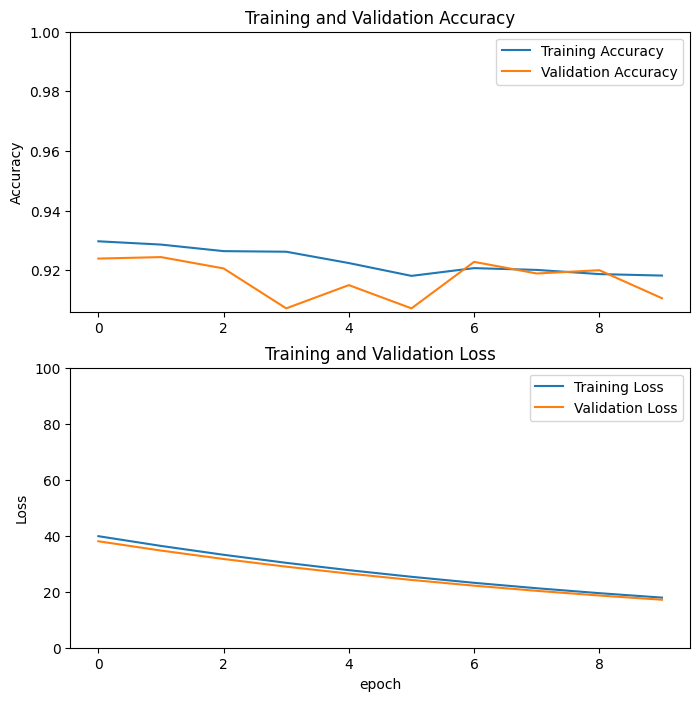

In [ ]:
#Get training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Code to make the accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy') #Give labels
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right') #Location of the legends, make sure not to disturb your visualization)
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

#Code to make the loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,100])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**CONVERT MODELTO H5**

In [ ]:
!pip install h5py
model.save('best_model.h5')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Check to make sure how the model define class indexes by default because we did not specify it above

# Obtain the class labels and indices mapping
class_indices = train_generator.class_indices

# Print the class labels and their corresponding indices
for label, index in class_indices.items():
    print(f"Class: {label} - Index: {index}")

Class: HDPE - Index: 0
Class: PET - Index: 1
Class: PP - Index: 2
